# Correlator Testing Notebook

### Import

In [2]:
import sys
sys.path.append(r"d:\Università\terzo anno\Tesi\astrocook")
from astrocook.functions import lines_voigt
from astropy.table import Table, vstack
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sps
from scipy.interpolate import interp1d
from tqdm import tqdm


[INFO] utils: NumExpr defaulting to 8 threads.


### Gestione dati

In [5]:
##MAIN##

spectrum = Table.read('test_20_100_spec.dat', format='ascii')
spectrum = Table([spectrum['x'], spectrum['y']], names=['wavelength', 'flux'])


In [6]:
wav_start = [154.8, 154.8, 155.06]
wav_end = [155.1, 154.85, 155.1]

#model parametrs
z = 0
logN = 12
b = 5
btur = 0
ion = 'CIV'


In [7]:
# models definition
models = [Table(), Table(), Table()]
for i in range(len(wav_start)):
    x = np.linspace(wav_start[i], wav_end[i], 1000)
    y = lines_voigt(x, z, logN, b, btur, ion)
    models[i] = Table([x, y], names=['wavelength', 'flux'])


In [8]:
#other parameters
threshold = 0.999
z_start = spectrum['wavelength'][0]/154.8 - 1
z_end = spectrum['wavelength'][-1]/155.1 - 1
#z_start = 2.56
#z_end = 2.63
dz = 1e-5

### Funzioni secondarie

In [9]:
#get indicies function
def get_indicies(flux, threshold):
    indicies = np.where(~(flux > threshold))[0]
    count = len(indicies)
    return indicies, count

# Function to convert bin to redshift
def bin_to_z(bin):
    return z_start + bin*dz

### Calcolo correlazione

In [10]:
cor_all = [np.array([]), np.array([]), np.array([])]

print("\n 3 models correlation calculation: \n - model 0 = full doublet \n - model 1 = left peak \n - model 2 = right peak \n")

for i,model in enumerate(models):
    for z in tqdm(np.arange(z_start, z_end, dz), "Calculating Correlation with model {}".format(i)):
        #moving the model to the redshift z
        new_model = Table([model['wavelength']*(1 + z), model['flux']], names=['wavelength', 'flux'])

        mask = (spectrum['wavelength'] > new_model['wavelength'].min()) & (spectrum['wavelength'] < new_model['wavelength'].max())    
        
        #selecting the data interval covered by the model
        spec_chunk = Table([spectrum['wavelength'][mask], spectrum['flux'][mask]], names=['wavelength', 'flux'])

        #interpolating the model to the data wavelength
        interpolate = interp1d(new_model['wavelength'], new_model['flux'], kind='linear')
        interpolated_flux = interpolate(spec_chunk['wavelength'])

        #identifying the indicies of the model that are below the threshold
        indicies, count = get_indicies(interpolated_flux, threshold)

        cor = np.correlate(interpolated_flux[indicies], spec_chunk['flux'][indicies], mode='valid')/count
        cor_all[i] = np.append(cor_all[i], cor)



 3 models correlation calculation: 
 - model 0 = full doublet 
 - model 1 = left peak 
 - model 2 = right peak 



Calculating Correlation with model 0:   0%|          | 0/52965 [00:00<?, ?it/s]

Calculating Correlation with model 1:  63%|██████▎   | 33178/52965 [01:13<00:43, 451.99it/s]


KeyboardInterrupt: 

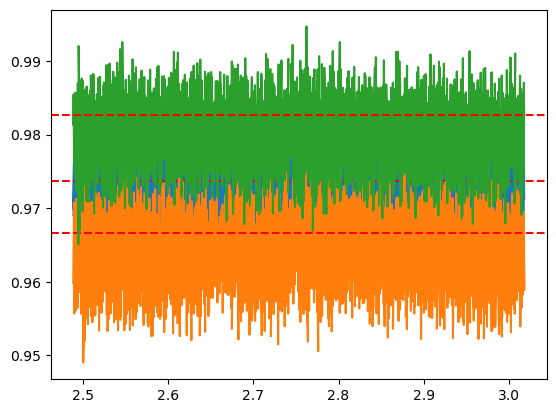

In [25]:
perc = 75

p0 = np.percentile(cor_all[0], perc)
p1 = np.percentile(cor_all[1], perc)
p2 = np.percentile(cor_all[2], perc)

cor_final = (p0 -cor_all[0])*(p1-cor_all[1])*(p2-cor_all[2])
#cor_normalized = (cor_final - cor_final.min())/(cor_final.max() - cor_final.min())
z_interval = np.arange(z_start, z_end, dz)

plt.plot(z_interval, cor_all[0], label='full doublet')
plt.axhline(p0, color='r', linestyle='--')
plt.plot(z_interval, cor_all[1], label='left peak')
plt.axhline(p1, color='r', linestyle='--')
plt.plot(z_interval, cor_all[2], label='right peak')
plt.axhline(p2, color='r', linestyle='--')


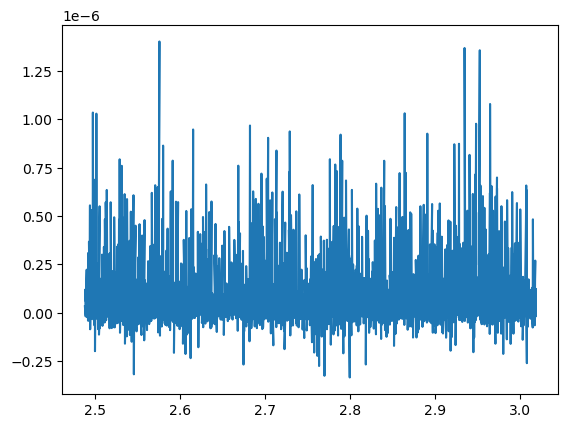

In [26]:
plt.plot(z_interval, cor_final, label='final correlation')

### Identificazione Picchi

In [29]:
from astrocook import vars
def get_dlambda(ion):
    elements = {key: value for key, value in vars.xem_d.items() if ion in key}
    dlambda = (np.abs(float(elements[list(elements.items())[0][0]].value) - float(elements[list(elements.items())[1][0]].value)))/float(elements[list(elements.items())[0][0]].value)

    return dlambda

In [30]:
# Finding the peaks
peaks, properties = sps.find_peaks(cor_final, height=np.mean(cor_final) + np.std(cor_final)*2, prominence=0, width=0.01, distance = 5e-4/dz)
peaks_table = Table([bin_to_z(peaks), properties['peak_heights'], properties['widths'], bin_to_z(properties['left_ips']), bin_to_z(properties['right_ips']), properties['width_heights'], properties['prominences']], names=['z', 'height', 'fwhm', 'left_z', 'right_z', 'half_max', 'prominence'])

len(peaks_table)

337

In [31]:
# Function to find the peaks studying the delta_z between the peaks
def find_systems(peaks_table, ion = 'CIV', z_tolerance = 0.1e-3, height_threshold = 3):
    
    for peak in peaks_table[peaks_table['height'] > np.mean(cor_final) + np.std(cor_final)*height_threshold]:
        # Defining the theoretical redshifts of the sx and dx peaks
        delta_lambda = get_dlambda(ion)
        delta_z = delta_lambda * (1 + peak['z'])

        sx_z = peak['z'] - delta_z
        dx_z = peak['z'] + delta_z

        # Defining the masks to find the sx and dx peaks within the z_tolerance
        sx_mask = (peaks_table['z'] < sx_z + z_tolerance) & (peaks_table['z'] > sx_z - z_tolerance)
        dx_mask = (peaks_table['z'] < dx_z + z_tolerance) & (peaks_table['z'] > dx_z - z_tolerance) 
        height_mask = (peaks_table['height'] < peak['height'])
        not_peak_z_mask = (peaks_table['z'] != peak['z'])

        #identifying the sx and dx peaks
        sx_peak = peaks_table[sx_mask & height_mask & not_peak_z_mask]
        dx_peak = peaks_table[dx_mask & height_mask & not_peak_z_mask]

        # Removing the secondary peaks
        if((len(sx_peak) >= 1) & (len(dx_peak) >= 1)):
            for sx in sx_peak:
                peaks_table = peaks_table[peaks_table['z'] != sx['z']]
            for dx in dx_peak:
                peaks_table = peaks_table[peaks_table['z'] != dx['z']]
                
    return peaks_table


In [32]:
height_threshold = 3
z_tolerance = 0.15e-3
ion = 'CIV'

print(peaks_table['z'])

possible_systems = find_systems(peaks_table, ion, z_tolerance , height_threshold)

print(possible_systems['z'])

        z         
------------------
2.4904979328165373
2.4913779328165373
 2.492437932816537
2.4932079328165373
 2.494347932816537
2.4959779328165372
2.4972179328165374
2.4977579328165374
2.4989979328165375
 2.500027932816537
               ...
2.9935579328165374
2.9946679328165375
2.9958879328165375
2.9986479328165374
 2.999767932816537
3.0003579328165375
 3.006817932816537
3.0146379328165374
 3.016637932816537
3.0173979328165372
Length = 337 rows
        z         
------------------
2.4904979328165373
2.4913779328165373
 2.492437932816537
 2.494347932816537
2.4959779328165372
2.4972179328165374
2.4977579328165374
2.4989979328165375
 2.500027932816537
2.5009579328165374
               ...
2.9935579328165374
2.9946679328165375
2.9958879328165375
2.9986479328165374
 2.999767932816537
3.0003579328165375
 3.006817932816537
3.0146379328165374
 3.016637932816537
3.0173979328165372
Length = 301 rows


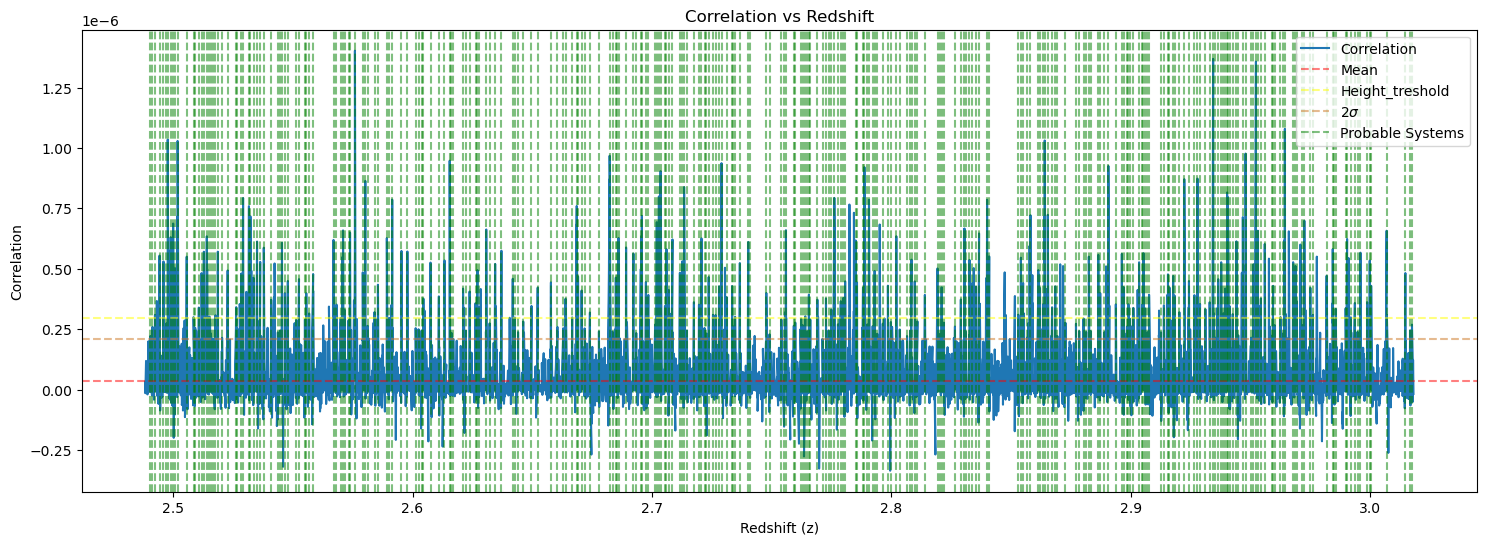

In [33]:

plt.figure(figsize = (18, 6))
plt.plot(z_interval, cor_final)
plt.axhline(np.mean(cor_final), color='r', linestyle='--', alpha=0.5)
plt.axhline(np.std(cor_final)*height_threshold + np.mean(cor_final), color='yellow', linestyle='--', alpha=0.5)
plt.axhline(np.std(cor_final)*2 + np.mean(cor_final), color='#CC7722', linestyle='--', alpha=0.5)

for system in possible_systems['z']:
    plt.axvline(x=system, color='g', linestyle='--', alpha=0.5)

plt.xlabel('Redshift (z)')
plt.ylabel('Correlation')
plt.title('Correlation vs Redshift')
plt.legend(['Correlation', 'Mean', r'Height_treshold', r'2$\sigma$', 'Probable Systems'])
plt.show()

In [34]:
synthetic_systems = [2.57352431, 2.66422603, 2.51803598, 2.22357274, 2.58163493, 2.21013991, 2.30970016, 2.82904971, 2.60683895, 2.95009428, 2.88590944, 2.27320993, 2.20884315, 3.08239514, 2.73699688, 2.30842111, 2.22430456, 2.68757115, 2.71786475, 2.98868828]


for i, p in enumerate(synthetic_systems):
    synthetic_systems[i] = round(p, 4)

n=0

not_found = []
for system in possible_systems['z']:
    system = round(system, 4)
    if(system in synthetic_systems):
        n+=1
        print(system, 'found')
    else:
        not_found.append(system)
        print(system, 'not found')

completness = n/len(synthetic_systems) * 100

print(completness, r'% of the synthetic systems have been found')
print(100 - completness, r'% of the synthetic systems have not been found')
print(len(not_found)/len(possible_systems)*100, r'% of the found systems are false positives')


2.4905 not found
2.4914 not found
2.4924 not found
2.4943 not found
2.496 not found
2.4972 not found
2.4978 not found
2.499 not found
2.5 not found
2.501 not found
2.5019 not found
2.5057 not found
2.5086 not found
2.5092 not found
2.5107 not found
2.5119 not found
2.5128 not found
2.5141 not found
2.5152 not found
2.5158 not found
2.5166 not found
2.5177 not found
2.5187 not found
2.5205 not found
2.5228 not found
2.5264 not found
2.5269 not found
2.5285 not found
2.5292 not found
2.5317 not found
2.5323 not found
2.5336 not found
2.5351 not found
2.5364 not found
2.5379 not found
2.5409 not found
2.5437 not found
2.5447 not found
2.5455 not found
2.5467 not found
2.5479 not found
2.5514 not found
2.5526 not found
2.5551 not found
2.5556 not found
2.5568 not found
2.5585 not found
2.567 not found
2.5682 not found
2.57 not found
2.571 not found
2.5716 not found
2.5733 not found
2.5739 not found
2.5759 not found
2.5792 not found
2.5803 not found
2.5813 not found
2.5841 not found
2.5855 

___________________________________

## Testing

In [3]:
import matplotlib.pyplot as plt
from correlator_v2_nofs import correlator
import numpy as np


In [4]:
def plot_correlation(cor_final, z_interval, possible_systems):
    plt.figure(figsize=(20, 12))
    plt.plot(z_interval, cor_final)
    plt.axhline(np.mean(cor_final), color='r', linestyle='--', alpha=0.5)
    plt.axhline(np.std(cor_final) * 3 + np.mean(cor_final), color='yellow', linestyle='--', alpha=0.5)
    plt.axhline(np.std(cor_final) * 2 + np.mean(cor_final), color='#CC7722', linestyle='--', alpha=0.5)

    for system in possible_systems:
        plt.axvline(x=system, color='g', linestyle='--', alpha=0.5)

    plt.xlabel('Redshift (z)')
    plt.ylabel('Correlation')
    plt.title('Correlation vs Redshift (nofs)')
    plt.legend(['Correlation', 'Mean', r'3$\sigma$', r'2$\sigma$', 'possible Systems'])
    plt.show()

In [5]:
cor_final, z_interval, peaks_table = correlator()

TypeError: correlator() missing 10 required positional arguments: 'spectrum_file', 'wav_start', 'wav_end', 'logN', 'b', 'btur', 'ion', 'threshold', 'dz', and 'perc'

        z                  height         ...       prominence      
------------------ ---------------------- ... ----------------------
2.5627079328165374  2.655846736504401e-07 ...  3.255511060874894e-07
2.5650879328165375  3.433529217653401e-07 ... 3.8847208683675387e-07
2.5669979328165375  6.194179271623956e-07 ...  6.510335303181352e-07
2.5682379328165372 3.5166160719659155e-07 ... 3.6634463609020935e-07
2.5699679328165375  2.969652342507514e-07 ... 2.9678749232132407e-07
2.5709779328165374  6.588379422635763e-07 ...  7.618865007629925e-07
2.5715979328165375 3.3032852112904653e-07 ...  3.527480337803281e-07
2.5732779328165374  2.866484323068672e-07 ...  2.878848813981131e-07
2.5738979328165374  6.493068341628445e-07 ...  6.786305030040204e-07
2.5759379328165375 1.4027416386165828e-06 ... 1.7225690237668249e-06
               ...                    ... ...                    ...
2.9935579328165374 3.5825011951728506e-07 ...  4.009155090776326e-07
2.9946679328165375 2.3869057086863

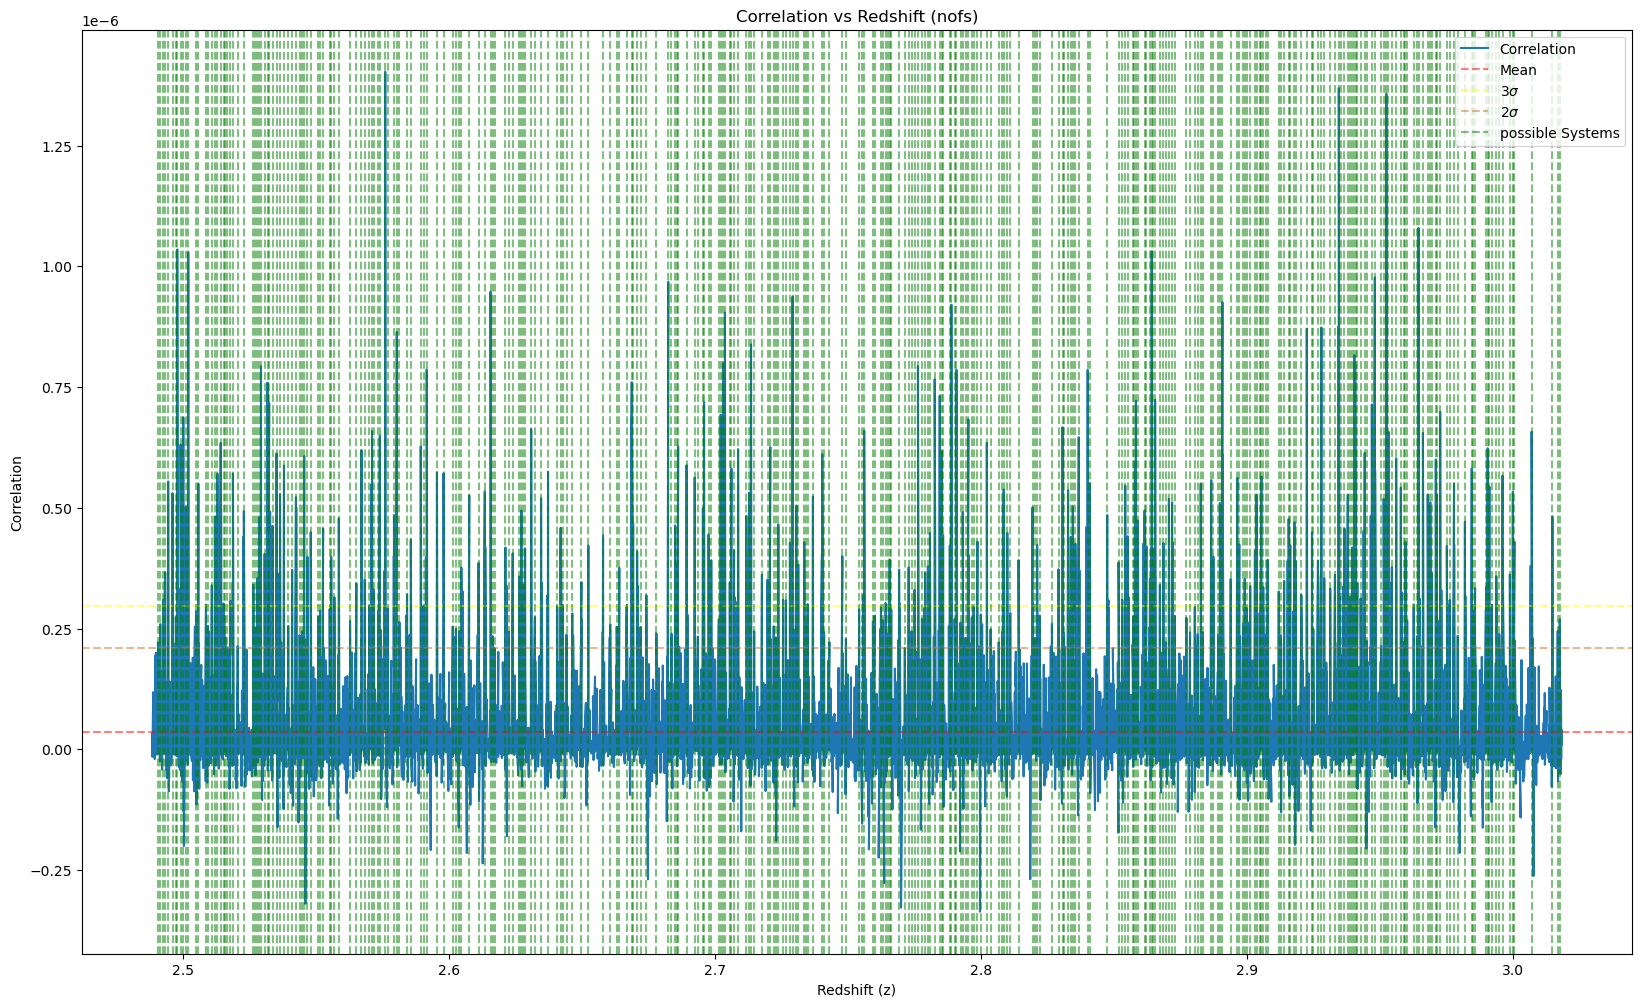

In [38]:
# Comparison with synthetic systems
synthetic_systems = [2.57352431, 2.66422603, 2.51803598, 2.22357274, 2.58163493, 2.21013991, 2.30970016, 2.82904971, 2.60683895, 2.95009428, 2.88590944, 2.27320993, 2.20884315, 3.08239514, 2.73699688, 2.30842111, 2.22430456, 2.68757115, 2.71786475, 2.98868828]
print(peaks_table[peaks_table['z'] > 2.56])

tp = sum(1 for system in peaks_table['z'] if any(abs(system - syn) < 1.665*b/3e5 for syn in synthetic_systems))

fp = len(peaks_table['z']) - tp
p = len(synthetic_systems)

recall = tp / p * 100
precision = tp / (tp+fp) * 100
f1 = 2 * tp / (tp + fp + p) * 100

print('Recall:', recall, '%')
print('Precision:', precision, '%')
print('F1 score:', f1, '%')

plot_correlation(cor_final, z_interval, peaks_table['z'])





In [6]:
def psf_gauss(x, resol):
        if len(x)==0:
            return []
        c = x[len(x)//2]
        sigma = c / resol * 4.246609001e-1

        psf = np.exp(-0.5*((x-c) / sigma)**2)
        psf = psf[np.where(psf > 1e-6)]
        return psf

In [7]:
import sys
sys.path.append(r"d:\Università\terzo anno\Tesi\astrocook")
from astrocook.functions import lines_voigt, convolve_simple

def correlator(spectrum_file, resol, wav_start, wav_end, logN, b, btur, ion, threshold, dz, perc):
    # Load spectrum
    spectrum = Table.read(spectrum_file, format='ascii')
    spectrum = Table([spectrum['x'], spectrum['y']], names=['wavelength', 'flux'])
        
    # Define models
    models = [Table(), Table(), Table()]
    for i in range(len(wav_start)):
        x = np.linspace(wav_start[i], wav_end[i], 1000)
        psf = psf_gauss(x, resol)
        voigt = lines_voigt(x, 0, logN, b, btur, ion)
        y = convolve_simple(voigt, psf)
        models[i] = Table([x, y], names=['wavelength', 'flux'])

    # Other parameters
    z_start = spectrum['wavelength'][0] / 154.8 - 1
    z_end = spectrum['wavelength'][-1] / 155.1 - 1

    return models, z_start, z_end, spectrum, threshold, dz, perc


In [8]:
models, z_start, z_end, spectrum, threshold, dz, perc = correlator('test_20_100_spec.dat', 45000, [154.8, 154.8, 155.06], [155.1, 154.85, 155.1], 12, 5, 0, 'CIV', 0.999, 1e-5, 75)

z = 2.55646069

mask = (spectrum['wavelength'] > (models[0]['wavelength'].min())*(1+z)) & (spectrum['wavelength'] < (models[0]['wavelength'].max())*(1+z))
spec_chunk = spectrum[mask]

print(spec_chunk)

#print((spec_chunk['wavelength'] * (1 + z)).min(), (spec_chunk['wavelength'] * (1 + z)).max())


wavelength    flux  
---------- ---------
 550.54399 0.9764284
   550.548 0.9889823
   550.552  1.002787
 550.55601 0.9880019
 550.56001 0.9961954
 550.56401 0.9883159
 550.56802 1.0031426
 550.57202 0.9944105
 550.57598 1.0228332
 550.57998 0.9991319
       ...       ...
 551.56802 0.9887999
 551.57202 0.9981318
 551.57598 0.9948256
 551.57998 0.9956945
 551.58398 1.0108364
 551.58799 1.0010609
 551.59199 0.9880113
   551.596 1.0064356
     551.6 0.9886903
   551.604 1.0066461
Length = 266 rows


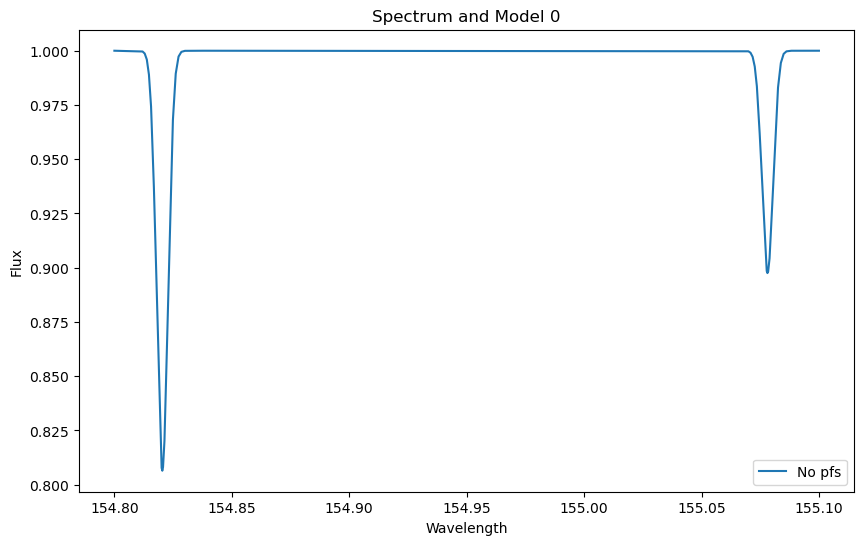

In [10]:
wav_start = [154.8, 154.8, 155.06]
wav_end = [155.1, 154.85, 155.1]

x = np.linspace(wav_start[0], wav_end[0], 1000)
logN = 12.5
b = 5
btur = 0
ion = 'CIV'
resol = 45000


plt.figure(figsize=(10, 6))
plt.plot(models[0]['wavelength'], convolve_simple(lines_voigt(x, 0, logN, b, btur, ion), psf_gauss(x, resol)), label='No pfs')
#plt.plot(models[0]['wavelength'], models[0]['flux'], label='convolved')
#plt.plot(spec_chunk['wavelength']/(1 + z), spec_chunk['flux'], label='Spectrum')

plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.title('Spectrum and Model 0')
plt.legend()
plt.show()

(0.98, 1.01)

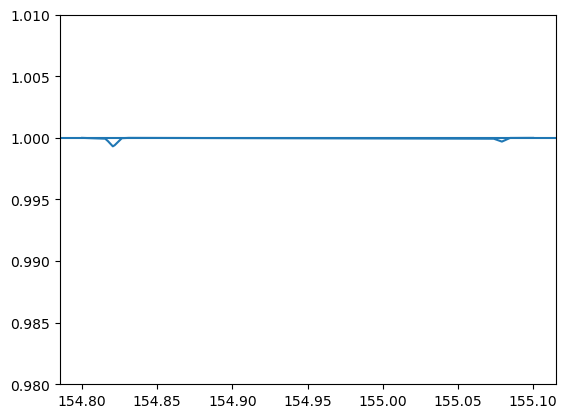

In [29]:
plt.plot(models[0]['wavelength'], convolve_simple(lines_voigt(x, 0, 10, b, btur, ion), psf_gauss(x, resol)), label='No pfs')
plt.axhline(0.99999999999)
plt.ylim(0.98, 1.01)